Shu Liu

https://www.linkedin.com/in/shuliuccb/

In [1]:
!conda install -c conda-forge beautifulsoup4 --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

print('Library installed.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Library installed.


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import requests
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import folium

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, jaccard_similarity_score, f1_score, log_loss, r2_score

print('Libraries imported.')

Libraries imported.


I. Project Summary:
    1. The Goal of the Project:
        To explore whether there is correlation between the neighborhoods and housing prices in New York city. If so, utilize machine learning algorithms to conduct the EDA on it.
    2. Methodology:
        In the project, we will mainly use the average price of 2-bedrooms condos in New York city (CityRealty), and the FourSquare API to extract the data of venues for each neighborhood.

II. Data Preparation

Part 1 Scrape CityRealty for neighborhood housing prices

In [284]:
# Using Beautiful Soup to parse the website's html
# The data of housing prices of third quarter of 2018 is limited, so we turn to June-2018
url = 'https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804'
data = requests.get(url).text
soup = BeautifulSoup(data, 'html.parser')

In [285]:
areaList = []
neighborhoodList = []

for area in soup.find_all('div', class_= 'tile _quote _n1 _last'):
    areaText = area.find("a").text
    areaList.append(areaText)
    
for index, table in enumerate(soup.find_all("table", class_="table table-bordered table-hover table-condensed")):
    for row in table.find_all("tr"):
        cells = row.find_all("td")
        if len(cells) > 0:
            neighborhoodName = cells[0].find("a").text.strip()
            avgPrice = cells[3].text.lstrip("$").strip()
            if "K" in avgPrice:
                avgPrice = float(avgPrice.rstrip("K")) * 1000
            else: 
                if "M" in avgPrice:
                    avgPrice = float(avgPrice.rstrip("M")) * 1000000
            
            neighborhoodList.append((
                areaList[index],
                neighborhoodName,
                avgPrice
            ))

In [286]:
# Put the scrapped data into a dataframe
nyc_neighborhoods_df = pd.DataFrame(neighborhoodList)
nyc_neighborhoods_df.columns = ['Area', 'Neighborhood', 'AvgPrice']

In [287]:
print(nyc_neighborhoods_df.shape)
nyc_neighborhoods_df.head()

(54, 3)


,Area,Neighborhood,AvgPrice
0,Brooklyn,Bedford-Stuyvesant,750000
1,Brooklyn,Boerum Hill,1.69e+06
2,Brooklyn,Brooklyn Heights,2.15e+06
3,Brooklyn,Bushwick,967000
4,Brooklyn,Carroll Gardens,1.51e+06


Part 2 Get the neighborhoods coordinate:


In [288]:
!wget -q -O 'nyc_geo.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


In [289]:
with open('nyc_geo.json') as nyc_geo_json:
    nyc_geo_data = json.load(nyc_geo_json)

In [290]:
nyc_geo_list = nyc_geo_data['features']
nyc_geo_list[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [291]:
#Parse the json data into lists
neighborhood_geo_list = []
for data in nyc_geo_list:
    borough = data['properties']['borough']
    name = data['properties']['name']
    location = data['geometry']['coordinates']
    lat = location[1]
    lng = location[0]
    
    neighborhood_geo_list.append((borough, name, lat, lng))

In [292]:
neighborhood_geo_df = pd.DataFrame(neighborhood_geo_list)
neighborhood_geo_df.columns = ['Borough','Neighborhood', 'Latitude','Longitude']
#So the average prices are only for the Brooklyn and Manhattan Borough.
neighborhood_geo_df = neighborhood_geo_df[(neighborhood_geo_df['Borough'] =='Manhattan') | (neighborhood_geo_df['Borough']=='Brooklyn')]

neighborhood_geo_df.reset_index(drop=True,inplace=True)
neighborhood_geo_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bensonhurst,40.611009,-73.995180
3,Brooklyn,Sunset Park,40.645103,-74.010316
4,Brooklyn,Greenpoint,40.730201,-73.954241


In [293]:
neighborhood_geo_df.shape

(110, 4)

Part 3 Combine the Two Dataframes

In [309]:
#Clean the neighborhood_geo_df
neighborhood_geo_df.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bensonhurst,40.611009,-73.995180
3,Brooklyn,Sunset Park,40.645103,-74.010316
4,Brooklyn,Greenpoint,40.730201,-73.954241
5,Brooklyn,Gravesend,40.595260,-73.973471
6,Brooklyn,Brighton Beach,40.576825,-73.965094
7,Brooklyn,Sheepshead Bay,40.586890,-73.943186
8,Brooklyn,Manhattan Terrace,40.614433,-73.957438
9,Brooklyn,Flatbush,40.636326,-73.958401


In [301]:
#Clean the data: some neighborhood names scrapped from the website don't match the names on the geo dataset.

'Bedford Stuyvesant'

In [302]:
# Bedford Stuyvesant missing a '-' in the middle
neighborhood_geo_df.at[18, 'Neighborhood'] = 'Bedford-Stuyvesant'

# Downtown is Downtown Brooklyn
neighborhood_geo_df.at[41, 'Neighborhood'] = 'Downtown Brooklyn'

# Dumbo should be DUMBO
neighborhood_geo_df.at[104, 'Neighborhood'] = 'DUMBO'

# Prospect Lefferts Gardens missing a '-' in the middle
nyc_neighborhoods_df.at[15, 'Neighborhood'] = 'Prospect-Lefferts Gardens'
neighborhood_geo_df.at[43, 'Neighborhood'] = 'Prospect-Lefferts Gardens'

# South Slope - Greenwood Heights is just South Slope
nyc_neighborhoods_df.at[17, 'Neighborhood'] = 'South Slope'
# South Slope coordinates is missing
neighborhood_geo_df = neighborhood_geo_df.append({'Borough': 'Brooklyn',
                                                  'Neighborhood': 'South Slope',
                                                  'Latitude': 40.662349, 
                                                  'Longitude': -73.990350}, ignore_index=True)

# Park, Fifth Ave to 79th St is Upper East Side
nyc_neighborhoods_df.at[24, 'Neighborhood'] = 'Upper East Side'

# Flatiron/Union Square is just Flatiron
nyc_neighborhoods_df.at[29, 'Neighborhood'] = 'Flatiron District'
neighborhood_geo_df.at[99, 'Neighborhood'] = 'Flatiron District'

# Gramercy Park is just Gramercy
nyc_neighborhoods_df.at[30, 'Neighborhood'] = 'Gramercy'

# NOHO should be just NoHo
nyc_neighborhoods_df.at[33, 'Neighborhood'] = 'NoHo'
neighborhood_geo_df.at[88, 'Neighborhood'] = 'NoHo'

# NoLiTa/Little Italy is just NoLiTa
nyc_neighborhoods_df.at[34, 'Neighborhood'] = 'NoLiTa'
neighborhood_geo_df.at[76, 'Neighborhood'] = 'NoLiTa'

# SOHO should be just SoHo
nyc_neighborhoods_df.at[35, 'Neighborhood'] = 'SoHo'
neighborhood_geo_df.at[77, 'Neighborhood'] = 'SoHo'

# Stuyvesant Town / PCV is just Stuyvesant Town
nyc_neighborhoods_df.at[36, 'Neighborhood'] = 'Stuyvesant Town'

# Beekman/Sutton Place is just Sutton Place
nyc_neighborhoods_df.at[39, 'Neighborhood'] = 'Sutton Place'

# Midtown East and Midtown West will be combined into Midtown
nyc_neighborhoods_df.at[40, 'Neighborhood'] = 'Midtown'
midtown_avg = (nyc_neighborhoods_df.at[40, 'AvgPrice'] + nyc_neighborhoods_df.at[41, 'AvgPrice']) / 2
nyc_neighborhoods_df.at[40, 'AvgPrice'] = midtown_avg
nyc_neighborhoods_df.at[41, 'AvgPrice'] = '-'

# Turtle Bay/United Nations is just Turtle Bay
nyc_neighborhoods_df.at[43, 'Neighborhood'] = 'Turtle Bay'

# Central Harlem is Harlem
neighborhood_geo_df.at[60, 'Neighborhood'] = 'Harlem'

# Lincoln Center is Lincoln Square
nyc_neighborhoods_df.at[51, 'Neighborhood'] = 'Lincoln Square'

# Broadway Cooridor, Central Park West and Riverside Dr./West End Ave. will be combined to Upper West Side
nyc_neighborhoods_df.at[49, 'Neighborhood'] = 'Upper West Side'
midtown_avg = (nyc_neighborhoods_df.at[49, 'AvgPrice'] + nyc_neighborhoods_df.at[50, 'AvgPrice'] + nyc_neighborhoods_df.at[53, 'AvgPrice']) / 3
nyc_neighborhoods_df.at[49, 'AvgPrice'] = midtown_avg
nyc_neighborhoods_df.at[50, 'AvgPrice'] = '-'
nyc_neighborhoods_df.at[53, 'AvgPrice'] = '-'

# Drop the Red Hook row
nyc_neighborhoods_df.drop([16], inplace=True)

In [303]:
nyc_df = pd.concat([nyc_neighborhoods_df.set_index('Neighborhood'), neighborhood_geo_df.set_index('Neighborhood')], axis=1, join='inner') 
nyc_df.drop(columns=['Area', 'Borough'], inplace=True)
nyc_df.reset_index(inplace=True)
nyc_df = nyc_df[['Neighborhood','AvgPrice','Latitude','Longitude']]
print(nyc_df.shape)
nyc_df.head() 

(50, 4)


,Neighborhood,AvgPrice,Latitude,Longitude
0,Bedford-Stuyvesant,750000,40.687232,-73.941785
1,Boerum Hill,1.69e+06,40.685683,-73.983748
2,Brooklyn Heights,2.15e+06,40.695864,-73.993782
3,Bushwick,967000,40.698116,-73.925258
4,Carroll Gardens,1.51e+06,40.680540,-73.994654


In [268]:
print(nyc_neighborhoods_df.shape)
nyc_neighborhoods_df.head()

(53, 3)


,Area,Neighborhood,AvgPrice
0,Brooklyn,Bedford-Stuyvesant,750000
1,Brooklyn,Boerum Hill,1.69e+06
2,Brooklyn,Brooklyn Heights,2.15e+06
3,Brooklyn,Bushwick,967000
4,Brooklyn,Carroll Gardens,1.51e+06


In [269]:
#Modify the nyc_neighborhoods_df
nyc_neighborhoods_df.columns = ['BOrough', 'Neighborhood', 'AvgPrice']

Part 4 Visualize on the Map

In [323]:
nyc_polygon_geo_data = r'nyc_geo.json'
latitude = 40.8021285
longitude = -73.9777254

In [324]:
#Map with markers

#First, create a plain map
nyc_map_markers = folium.Map(location=[latitude, longitude], zoom_start=11)

#Generate choropleth map
nyc_map_markers.choropleth(
    geo_data = nyc_polygon_geo_data,
    data = nyc_df,
    columns = ['Neighborhood', 'AvgPrice'],
    key_on = 'feature.properties.neighborhood',
    fill_color = 'YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name = 'Average price of 2 bedrooms conda in NY City')

#Add markers to map
for lat, lng, neighborhood, price in zip(nyc_df['Latitude'], nyc_df['Longitude'], nyc_df['Neighborhood'], nyc_df['AvgPrice']):
    label = '{}, ${:3.0f}'.format(neighborhood, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_map_markers)
    
nyc_map_markers    

Part 5 Using FourSquare API to get surrounding venues

In [325]:
CLIENT_ID = '1SW4RDZUBV2QC04NRDIJVFLUQ13PYAKGB4PIDY0WGNAOUDTX'
CLIENT_SECRET = 'S4MIIPJV0JSAFRTV1HG1V2IO3WMIED1FUF3KD14STTYB4FDI'
VERSION = '20180605'

In [334]:
#To explore 1km venues around the neighborhood
r = 1000
limit = 200

venues = []

for lat, lng, neighborhood in zip(nyc_df['Latitude'], nyc_df['Longitude'], nyc_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        r, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [337]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLat', 'VenueLng', 'Category']
print(venues_df.shape)
venues_df.head()

(5000, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLat,VenueLng,Category
0,Bedford-Stuyvesant,40.687232,-73.941785,Sincerely Tommy,40.686066,-73.944294,Boutique
1,Bedford-Stuyvesant,40.687232,-73.941785,Bed-Vyne Brew,40.684751,-73.944319,Bar
2,Bedford-Stuyvesant,40.687232,-73.941785,Bed-Vyne Wine & Spirits,40.684668,-73.944363,Wine Shop
3,Bedford-Stuyvesant,40.687232,-73.941785,The Bush Doctor,40.687399,-73.944480,Juice Bar
4,Bedford-Stuyvesant,40.687232,-73.941785,Eugene & Co,40.683899,-73.944023,New American Restaurant


In [339]:
#One hot encoding
venues_type = pd.get_dummies(venues_df[['Category']], prefix = '', prefix_sep = '')

venues_type['Neighborhood'] = venues_df['Neighborhood']
fix_columns = list(venues_type.columns[-1:]) + list(venues_type.columns[:-1])
venues_type = venues_type[fix_columns]

print(venues_type.shape)
venues_type.head()

(5000, 342)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bedford-Stuyvesant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bedford-Stuyvesant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bedford-Stuyvesant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Bedford-Stuyvesant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bedford-Stuyvesant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [342]:
venue_count = venues_type.groupby(['Neighborhood']).sum().reset_index()
print(venue_count.shape)
venue_count.head()

(50, 342)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,4,0,1,0
1,Bedford-Stuyvesant,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,5,0,0,1
2,Boerum Hill,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,2,0,0,2
3,Brooklyn Heights,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,5
4,Bushwick,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,2,0,0,2


In [343]:
# Standardize AvgPrice of Neighbors
scaler = StandardScaler()
standardized_p = scaler.fit_transform(nyc_df[['AvgPrice']])

#Add to the df
venues_price = pd.DataFrame(venue_count)
venues_price['StandardizedPrice'] = standardized_p
print(venues_price.shape)
venues_price.head()

(50, 343)


/Users/sfdatabro/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sfdatabro/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,StandardizedPrice
0,Battery Park City,0,0,0,2,0,1,0,0,0,...,0,0,0,0,0,4,0,1,0,-1.303912
1,Bedford-Stuyvesant,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,5,0,0,1,-0.418350
2,Boerum Hill,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,2,0,0,2,0.015011
3,Brooklyn Heights,0,0,0,3,0,0,0,0,0,...,1,0,0,0,0,4,0,0,5,-1.099479
4,Bushwick,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,2,0,0,2,-0.587926


III. Looking into the dataframe

Part1 Calculate the correlation between Counts of venues and StandardizedPrice

In [346]:
#Using LinearRegression to calculate the coeffcient correlations
lm = LinearRegression(normalize = True)

x = venues_price.drop(columns = ['Neighborhood', 'StandardizedPrice'])
y = venues_price['StandardizedPrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

model = lm.fit(x_train, y_train)

In [348]:
y_hat = lm.predict(x_test)

print('R2-score: ', r2_score(y_test, y_hat))
print('Mean Squared Error:',mean_squared_error(y_test, y_hat))

print('Max positive coef: ', lm.coef_[np.argsort(-lm.coef_)[:10]])
print('Venue category with the max positive coef: ', x.columns[np.argsort(lm.coef_)[:10]].values)

print('Max negative coef: ', lm.coef_[np.argsort(lm.coef_)[:10]])
print('Venue category with the max negative coef: ', x.columns[np.argsort(lm.coef_)[:10]].values)

coef_abs = abs(lm.coef_)

print('Min coefs:', lm.coef_[np.argsort(coef_abs)[:10]])
print('Venue category with the min abs coef: ', x.columns[np.argsort(coef_abs)[:10]].values)


R2-score:  0.1832069930749649
Mean Squared Error: 0.28588544189397047
Max positive coef:  [0.48752749 0.27077384 0.25813291 0.25813291 0.25813291 0.23290352
 0.23290352 0.21816018 0.21541697 0.21445262]
Venue category with the max positive coef:  ['Newsstand' "Dentist's Office" 'Sports Club' 'Reservoir' 'Food' 'Office'
 'Photography Studio' 'Golf Driving Range' 'Smoothie Shop' 'Mini Golf']
Max negative coef:  [-0.25821447 -0.19682403 -0.19682403 -0.17862462 -0.16952273 -0.16846253
 -0.16846253 -0.16846253 -0.16846253 -0.16265707]
Venue category with the max negative coef:  ['Newsstand' "Dentist's Office" 'Sports Club' 'Reservoir' 'Food' 'Office'
 'Photography Studio' 'Golf Driving Range' 'Smoothie Shop' 'Mini Golf']
Min coefs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Venue category with the min abs coef:  ['Molecular Gastronomy Restaurant' 'Indoor Play Area'
 'Pakistani Restaurant' 'State / Provincial Park' 'General Entertainment'
 'Volleyball Court' 'Shipping Store' 'Cemetery' 'Gym Pool' 'Gas 

Thus, the results don't look that promising.
- The R2-score is too small.
- The correlations are too many and strong.

In [ ]:
#Applying PCR for better adaptation

PCR (Principal Component Regression) is a regression which is based on PCA (Principal Component Analysis).
- First, we perform PCA on the features dataset to obtain the principal components. 
- Second, use linear regression on the subset selected from step1 to get the coefficients.

In [349]:
x = venues_price.drop(columns = ['Neighborhood', 'StandardizedPrice'])
y = venues_price['StandardizedPrice']

pca = PCA(svd_solver = 'auto', random_state = 0)
x_pca = pca.fit_transform(scale(x))

/Users/sfdatabro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
  """


In [351]:
component_list = range(1,51)
r2_list = []
mse_list = []

# Perform LinearRegression
for i in component_list:
    lm = LinearRegression()
    x_train, x_test, y_train, y_test = train_test_split(x_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lm.fit(x_train, y_train)
    
    y_hat = lm.predict(x_test)
    r2 = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    r2_list.append(r2)
    mse_list.append(mse)
    
pca_scores = pd.DataFrame.from_dict(dict([('NumberOfCompo', component_list),
                                         ('r2-score', r2_list),
                                         ('mse', mse_list)]))

pca_scores.set_index('NumberOfCompo', inplace=True)
print(pca_scores.shape)
pca_scores.head()

(50, 2)


,r2-score,mse
NumberOfCompo,,
1,0.209416,0.276712
2,0.162273,0.293213
3,0.381534,0.216469
4,0.387934,0.214229
5,0.363462,0.222795


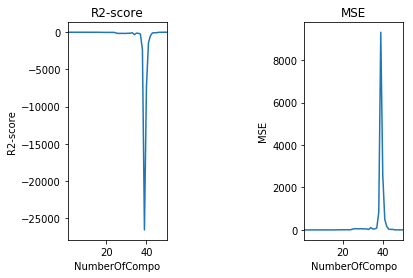

In [353]:
#Plot scores
plt.subplot(1,3,1)

pca_scores['r2-score'].plot(kind='line')
plt.title('R2-score')
plt.xlabel('NumberOfCompo')
plt.ylabel('R2-score')

plt.subplot(1,3,3)
pca_scores['mse'].plot(kind='line')
plt.title('MSE')
plt.xlabel('NumberOfCompo')
plt.ylabel('MSE')

plt.show()

In [354]:
# Find the max n
# The best n is at when r2-score maximized
r2_max = pca_scores['r2-score'].idxmax()
print('The Best n: ', r2_max, 'at R2 score: ', pca_scores['r2-score'][r2_max])

# The best n is at when mse minimized
mse_min = pca_scores['mse'].idxmin()
print('The Best n: ', mse_min, 'at MSE: ', pca_scores['mse'][mse_min])

The Best n:  4 at R2 score:  0.3879341509356644
The Best n:  4 at MSE:  0.2142289591664262


In [359]:
# Use the best n
lm = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(x_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lm.fit(x_train, y_train)

y_hat = lm.predict(x_test)
r2 = r2_score(y_test, y_hat)
mse = mean_squared_error(y_test, y_hat)

print('R2 score: ', r2)
print('MSE: ', mse)

R2 score:  0.3879341509356644
MSE:  0.2142289591664262


In [360]:
#Thus, the result has been improved.
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lm.coef_

pcr_coefs.shape

(341,)

In [364]:
#Finding which venue category has the most and least effect
print('Max positive coefs: ', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('Venue category with the max positive coefs:',  x.columns[np.argsort(-pcr_coefs)[:10]].values)

print('Max negative coefs: ', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('Venue category with the max negative coefs: ', x.columns[np.argsort(pcr_coefs)[:10]].values)

coef_abs = abs(pcr_coefs)
print('Min coefs: ', pcr_coefs[np.argsort(coef_abs)[:10]])
print('Venue category with the min coefs: ', x.columns[np.argsort(coef_abs)[:10]].values)

Max positive coefs:  [0.01195587 0.0119087  0.01181722 0.0116917  0.01067889 0.01010339
 0.00974116 0.00969703 0.009341   0.00926025]
Venue category with the max positive coefs: ['Beer Bar' 'Salon / Barbershop' 'Speakeasy' 'Dessert Shop' 'Boutique'
 'Greek Restaurant' 'Sake Bar' 'Seafood Restaurant' 'Wine Bar'
 'Art Gallery']
Max negative coefs:  [-0.01946905 -0.01684975 -0.01631102 -0.01631102 -0.01557971 -0.01451633
 -0.01451633 -0.01451633 -0.01402592 -0.0137282 ]
Venue category with the max negative coefs:  ['Shopping Mall' 'Memorial Site' 'Auditorium' "Doctor's Office" 'Market'
 'Tree' 'Cooking School' 'Strip Club' 'Coworking Space' 'Coffee Shop']
Min coefs:  [-8.93021696e-06  1.04970096e-05  5.07004381e-05 -6.37943185e-05
  9.03717302e-05 -1.03745967e-04 -1.03745967e-04 -1.58561976e-04
 -1.67727209e-04  1.74711797e-04]
Venue category with the min coefs:  ['Cocktail Bar' 'Exhibit' 'Used Bookstore' 'Israeli Restaurant' 'Theater'
 'Food Stand' 'Pakistani Restaurant' 'Gift Shop' 'Gym

IV. Conclusion:
Actually, the result seems not very promising as the R2 score is still small. That is to say, using the simple LinearRegression is not very promising in finding the correlation between the housing prices and the venue categories nearby. To precisely predict the correlation, we need more methods.

Although, after filtering the best n for conduting regression again or performing PCA, the results can be improved.

In some ways, as we can observe from the real life, the neighborhoods with some fancy venues such as bars, salon shop, speakeasy, seem to have higher housing prices. And in the other way, the neighborhoods with the most shopping mall, memorial site, seem to have lower housing prices.